"""
~ task: Evaluate classification confussion matrix ~

@ author: Teodora Trandafir 

"""

In [1]:
""" Update """

' Update '

In [2]:
import datetime

import numpy as np 
%matplotlib inline
import math
import random

import matplotlib.pyplot as plt
import datetime
import json
import pandas as pd
import six
import csv

import os
import glob 
import sys
import shutil
from skimage import io
from scipy import misc

#import cv2
from PIL import Image

import tensorflow as tf
from tensorflow.python.framework import tensor_util
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras.models import model_from_json, Sequential
from tensorflow.keras.applications import InceptionResNetV2, ResNet50 
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Lambda, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.activations import softmax
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, History, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import DirectoryIterator, ImageDataGenerator


import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, multilabel_confusion_matrix, classification_report, confusion_matrix,RocCurveDisplay
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder

In [5]:
print(tf.__version__)
tf.config.list_physical_devices('GPU')
print(sklearn.__version__)

2.8.0
1.1.0


2024-08-01 14:16:01.690549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-01 14:16:01.713742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-01 14:16:01.713842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [6]:
!nvidia-smi

Thu Aug  1 14:16:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
|  0%   32C    P8             16W /  420W |     277MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#### Session settings

In [7]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.compat.v1.Session(config=config)

2024-08-01 14:16:01.890989: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 14:16:01.891552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-01 14:16:01.891695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-01 14:16:01.891783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

#### Work directory configurations

In [8]:
print(os.getcwd())
os.chdir('..')
print(os.getcwd())

/mnt/storage/Projects/04_LCNEC/Principal
/mnt/storage/Projects/04_LCNEC


#### Experiment date

In [9]:
current_date = datetime.datetime.today().strftime('%Y-%m-%d')+"_"
print(current_date)

2024-08-01_


#### Input ocation 

In [10]:
project_path = os.getcwd()

root_path = project_path + os.sep + 'Principal'
data_path = project_path + os.sep + 'LCNEC_128_Consensus'
folds_path = project_path + os.sep + 'LCNEC_128_Consensus_4folds'
save_path = project_path + os.sep + 'augument'

test_path_validation = folds_path + os.sep + 'Fold31/Validation'
test_path_biopsies =  project_path + os.sep + 'Test_biopsies'
test_path_all =  project_path + os.sep + 'Test_all'


#### Input settings

In [11]:
""" Set data info """

DISEASE = 'LCNEC_RB_consensus4'

CLASSES = ([name for name in os.listdir(data_path)])
print(CLASSES)
N_CLASSES = len(CLASSES)
class_weights = None

""" Set experiments repeats """
N_FOLDS = 4
N_RUNS = 1

"""Evaluated fold"""
#foldN = 3
runN = 1


""" Set model parameters """
MODEL_ARCH = 'teonet_u2'
LOSS_FUNC = 'BBCE'
PATCH_SIZE = 128
DOWNSIZING_FACTOR = 1 # 1 for original image size
PATCH_SIZE = int(PATCH_SIZE/DOWNSIZING_FACTOR) # both height and width
BATCH_SIZE = 128 * DOWNSIZING_FACTOR * DOWNSIZING_FACTOR
LR = 1e-4

""" Set randomization parameters """
SHUFFLE = False
SEED = 1

""" Set required metrics evaluation """
METRICS = ['Accuracy']


['1', '0']


In [12]:
exp_path = '{}/Experiments/{}_{}_{}_{}_{}/'.format(project_path,DISEASE,MODEL_ARCH,LOSS_FUNC,N_CLASSES,PATCH_SIZE)

#### Output location

In [13]:
weights_path = '{}/Experiments/{}_{}_{}_{}_{}/weights_data/'.format(project_path,DISEASE,MODEL_ARCH,LOSS_FUNC,N_CLASSES,PATCH_SIZE)

#### Import model weights

In [14]:
model_weights = weights_path+"Fold31/Weights_LCNEC_RB_consensus4_V11_teonet_u2_BBCE_2_128_31_42_1.05.hdf5" ### this is fold 3

#### Test data evaluation

#### Generator setup

In [15]:
augmentation_arguments_test = dict(featurewise_center = False,
                                    samplewise_center = False,
                                    featurewise_std_normalization = False,
                                    samplewise_std_normalization = False,
                                    rotation_range = None,
                                    brightness_range = None,
                                    horizontal_flip = False,
                                    vertical_flip = False,
                                    rescale = 1./255.,
                                    # fill_mode = "constant",
                                    # cval = 255.0,
                                    preprocessing_function = None)  #    tf.keras.applications.resnet_v2.preprocess_input)

test_datagen_validation = ImageDataGenerator(**augmentation_arguments_test).flow_from_directory(directory = test_path_validation,
                                                                                    batch_size = BATCH_SIZE, 
                                                                                    target_size = (PATCH_SIZE,PATCH_SIZE),
                                                                                    color_mode= "rgb",
                                                                                    class_mode = "binary", 
                                                                                    #classes = CLASSES,
                                                                                    seed= SEED,
                                                                                    shuffle = SHUFFLE)

test_datagen_all = ImageDataGenerator(**augmentation_arguments_test).flow_from_directory(directory = test_path_all,
                                                                                    batch_size = BATCH_SIZE, 
                                                                                    target_size = (PATCH_SIZE,PATCH_SIZE),
                                                                                    color_mode= "rgb",
                                                                                    class_mode = "binary", 
                                                                                    #classes = CLASSES,
                                                                                    seed= SEED,
                                                                                    shuffle = SHUFFLE)

test_datagen_biopsies = ImageDataGenerator(**augmentation_arguments_test).flow_from_directory(directory = test_path_biopsies,
                                                                                    batch_size = BATCH_SIZE, 
                                                                                    target_size = (PATCH_SIZE,PATCH_SIZE),
                                                                                    color_mode= "rgb",
                                                                                    class_mode = "binary", 
                                                                                    #classes = CLASSES,
                                                                                    seed= SEED,
                                                                                    shuffle = SHUFFLE)


Found 6762 images belonging to 2 classes.
Found 20161 images belonging to 2 classes.
Found 8878 images belonging to 2 classes.


In [17]:
""" Set required functions """
OPTIMIZER = Adam(learning_rate=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4, amsgrad=False, name='Adam') 

LOSS = 'binary_crossentropy'

#### Fit Model

In [18]:
from model_u2 import *

model = create_binary_classification_model(input_shape=(PATCH_SIZE, PATCH_SIZE, 3))

model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

# Summary of the model architecture
#model_1.summary()


2024-08-01 14:16:02.533684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-01 14:16:02.533865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-01 14:16:02.533964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-01 14:16:02.534089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-01 14:16:02.534182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [19]:
model.load_weights(model_weights)

In [20]:
target_names = []
for key in test_datagen_all.class_indices:
    target_names.append(key)
print(target_names)

['0', '1']


In [21]:
#Confution Matrix

Y_pred_validation = model.predict(test_datagen_validation)
y_pred_validation = (Y_pred_validation>0.5)

#y_pred = np.argmax(Y_pred, axis=1)
Y_pred_all = model.predict(test_datagen_all)
y_pred_all = (Y_pred_all>0.5)

Y_pred_biopsies = model.predict(test_datagen_biopsies)
y_pred_biopsies = (Y_pred_biopsies>0.5)


2024-08-01 14:16:03.165354: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2024-08-01 14:16:04.494492: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


## Patchwise Confusion Matrices

In [22]:
cm_validation = confusion_matrix(test_datagen_validation.classes, y_pred_validation)
cm_normalized_validation = cm_validation.astype('float') / cm_validation.sum(axis=1)[:, np.newaxis]

cm_all = confusion_matrix(test_datagen_all.classes, y_pred_all)
cm_normalized_all = cm_all.astype('float') / cm_all.sum(axis=1)[:, np.newaxis]

cm_biopsies = confusion_matrix(test_datagen_biopsies.classes, y_pred_biopsies)
cm_normalized_biopsies = cm_biopsies.astype('float') / cm_biopsies.sum(axis=1)[:, np.newaxis]

In [23]:
# Combine unnormalized and normalized values in one matrix
combined_matrix_validation = np.array([[
    f'{value}\n({normalized:.2%})' for value, normalized in zip(row, normalized_row)
] for row, normalized_row in zip(cm_validation, cm_normalized_validation)])

combined_matrix_all = np.array([[
    f'{value}\n({normalized:.2%})' for value, normalized in zip(row, normalized_row)
] for row, normalized_row in zip(cm_all, cm_normalized_all)])

combined_matrix_biopsies = np.array([[
    f'{value}\n({normalized:.2%})' for value, normalized in zip(row, normalized_row)
] for row, normalized_row in zip(cm_biopsies, cm_normalized_biopsies)])

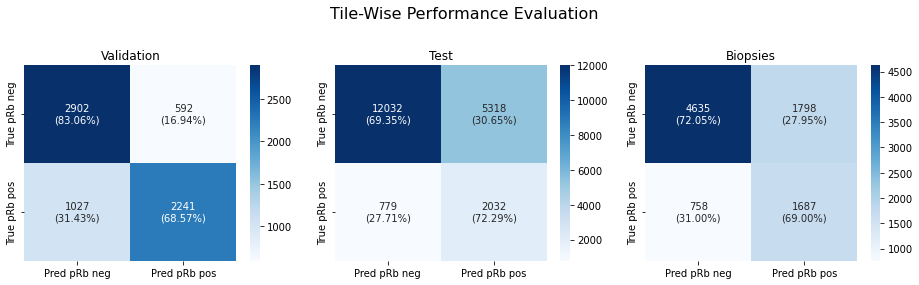

In [24]:
import seaborn as sns

# Create a figure with 5 subplots arranged horizontally
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

sns.heatmap(cm_validation, annot=combined_matrix_validation, fmt='', cmap='Blues', cbar=True, ax=axes[0], xticklabels=['Pred pRb neg', 'Pred pRb pos'], yticklabels=['True pRb neg', 'True pRb pos'])
axes[0].set_title('Validation')
# axes[0].set_xlabel('Predicted')
# axes[0].set_ylabel('True')

sns.heatmap(cm_all, annot=combined_matrix_all, fmt='', cmap='Blues', cbar=True, ax=axes[1], xticklabels=['Pred pRb neg', 'Pred pRb pos'], yticklabels=['True pRb neg', 'True pRb pos'])
axes[1].set_title('Test')
# axes[0].set_xlabel('Predicted')
# axes[0].set_ylabel('True')

sns.heatmap(cm_biopsies, annot=combined_matrix_biopsies, fmt='', cmap='Blues', cbar=True, ax=axes[2], xticklabels=['Pred pRb neg', 'Pred pRb pos'], yticklabels=['True pRb neg', 'True pRb pos'])
axes[2].set_title('Biopsies')
# axes[0].set_xlabel('Predicted')
# axes[0].set_ylabel('True')

plt.suptitle('Tile-Wise Performance Evaluation', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(exp_path + "/All_tiles_Confusion_Matrices.png")
plt.show()


## Patchwise ROC-AUCs

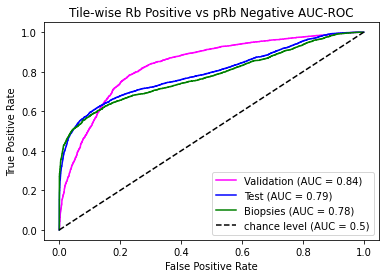

In [25]:
plt.figure(figsize=(6, 4))
RocCurveDisplay.from_predictions(test_datagen_validation.classes, Y_pred_validation, name=f"Validation", color="magenta", ax=plt.gca())
RocCurveDisplay.from_predictions(test_datagen_all.classes, Y_pred_all, name=f"Test", color="blue", ax=plt.gca())
RocCurveDisplay.from_predictions(test_datagen_biopsies.classes, Y_pred_biopsies, name=f"Biopsies", color="green", ax=plt.gca())

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.title("Tile-wise Rb Positive vs pRb Negative AUC-ROC")
plt.legend()
plt.savefig(exp_path + "/All_tiles_ROC_AUC.png")
plt.show()

# Patient level implementation

In [26]:
excel_file_validation = exp_path + "Validation_Patient_Prediction_Consensus.xlsx"
excel_file_all = exp_path + "Test_Patient_Prediction_Consensus.xlsx"
excel_file_biopsies = exp_path + "Biopsies_Patient_Prediction_Consensus.xlsx"

In [27]:
data_validation = pd.read_excel(excel_file_validation, sheet_name='Fold_3')
class_true_validation = data_validation['Class_true'].tolist()
class_pred_validation = data_validation['Class_predicted'].tolist()

data_all = pd.read_excel(excel_file_all, sheet_name='Fold_3')
class_true_all = data_all['Class_true'].tolist()
class_pred_all = data_all['Class_predicted'].tolist()

data_biopsies = pd.read_excel(excel_file_biopsies, sheet_name='Fold_3')
class_true_biopsies = data_biopsies['Class_true'].tolist()
class_pred_biopsies = data_biopsies['Class_predicted'].tolist()

## Patientwise Confusion Matrices

In [28]:
cm_pvalidation = confusion_matrix(class_true_validation, class_pred_validation)
cm_normalized_pvalidation = cm_pvalidation.astype('float') / cm_pvalidation.sum(axis=1)[:, np.newaxis]

cm_pall = confusion_matrix(class_true_all, class_pred_all)
cm_normalized_pall = cm_pall.astype('float') / cm_pall.sum(axis=1)[:, np.newaxis]

cm_pbiopsies = confusion_matrix(class_true_biopsies, class_pred_biopsies)
cm_normalized_pbiopsies = cm_pbiopsies.astype('float') / cm_pbiopsies.sum(axis=1)[:, np.newaxis]

In [29]:
# Combine unnormalized and normalized values in one matrix
combined_matrix_pvalidation = np.array([[
    f'{value}\n({normalized:.2%})' for value, normalized in zip(row, normalized_row)
] for row, normalized_row in zip(cm_pvalidation, cm_normalized_pvalidation)])

combined_matrix_pall = np.array([[
    f'{value}\n({normalized:.2%})' for value, normalized in zip(row, normalized_row)
] for row, normalized_row in zip(cm_pall, cm_normalized_pall)])

combined_matrix_pbiopsies = np.array([[
    f'{value}\n({normalized:.2%})' for value, normalized in zip(row, normalized_row)
] for row, normalized_row in zip(cm_pbiopsies, cm_normalized_pbiopsies)])

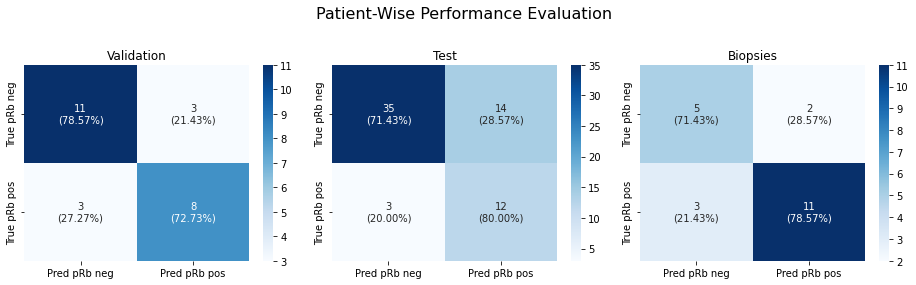

In [30]:
import seaborn as sns

# Create a figure with 5 subplots arranged horizontally
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

sns.heatmap(cm_pvalidation, annot=combined_matrix_pvalidation, fmt='', cmap='Blues', cbar=True, ax=axes[0], xticklabels=['Pred pRb neg', 'Pred pRb pos'], yticklabels=['True pRb neg', 'True pRb pos'])
axes[0].set_title('Validation')
# axes[0].set_xlabel('Predicted')
# axes[0].set_ylabel('True')

sns.heatmap(cm_pall, annot=combined_matrix_pall, fmt='', cmap='Blues', cbar=True, ax=axes[1], xticklabels=['Pred pRb neg', 'Pred pRb pos'], yticklabels=['True pRb neg', 'True pRb pos'])
axes[1].set_title('Test')
# axes[0].set_xlabel('Predicted')
# axes[0].set_ylabel('True')

sns.heatmap(cm_pbiopsies, annot=combined_matrix_pbiopsies, fmt='', cmap='Blues', cbar=True, ax=axes[2], xticklabels=['Pred pRb neg', 'Pred pRb pos'], yticklabels=['True pRb neg', 'True pRb pos'])
axes[2].set_title('Biopsies')
# axes[0].set_xlabel('Predicted')
# axes[0].set_ylabel('True')

plt.suptitle('Patient-Wise Performance Evaluation', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(exp_path + "/All_patients_Confusion_Matrices.png")
plt.show()


## Patientwise ROC-AUCs

In [31]:
number_patches_validation = data_validation['Number_patches'].tolist()
class_1_validation = data_validation['Class_1'].tolist()

probability_prediction_validation = []
for i in range(0,len(number_patches_validation)):
    probability_prediction_validation.append(class_1_validation[i]/number_patches_validation[i])
   
    
number_patches_all = data_all['Number_patches'].tolist()
class_1_all = data_all['Class_1'].tolist()

probability_prediction_all = []
for i in range(0,len(number_patches_all)):
    probability_prediction_all.append(class_1_all[i]/number_patches_all[i])
    
    
number_patches_biopsies = data_biopsies['Number_patches'].tolist()
class_1_biopsies = data_biopsies['Class_1'].tolist()

probability_prediction_biopsies = []
for i in range(0,len(number_patches_biopsies)):
    probability_prediction_biopsies.append(class_1_biopsies[i]/number_patches_biopsies[i])

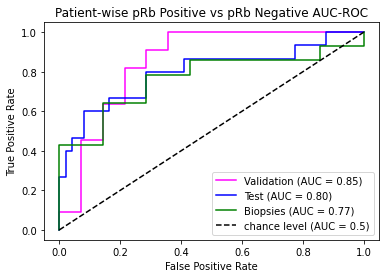

In [32]:
plt.figure(figsize=(6, 4))
RocCurveDisplay.from_predictions(class_true_validation, probability_prediction_validation, name=f"Validation", color="magenta", ax=plt.gca())
RocCurveDisplay.from_predictions(class_true_all, probability_prediction_all, name=f"Test", color="blue", ax=plt.gca())
RocCurveDisplay.from_predictions(class_true_biopsies, probability_prediction_biopsies, name=f"Biopsies", color="green", ax=plt.gca())

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.title("Patient-wise pRb Positive vs pRb Negative AUC-ROC")
plt.legend()
plt.savefig(exp_path + "/All_patients_ROC_AUC.png")
plt.show()